<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with VGG16 Architecture</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/Model Training/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [ ]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize

**Importing Libraries**

In [ ]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

In [ ]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'
path_to_save_model=r"/content/drive/MyDrive/AI Project/Model Training/"

**Load the datasets into train_loader, validation loader and test loader**

In [ ]:
train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.3, val_split=0.1, batch_size=32, input_size=[64,64])

In [ ]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([3, 3, 0, 3, 3, 0, 2, 3, 1, 0])


**Encodings for the classes**

In [ ]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)

label mapping is  {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


**Plot the data loader**

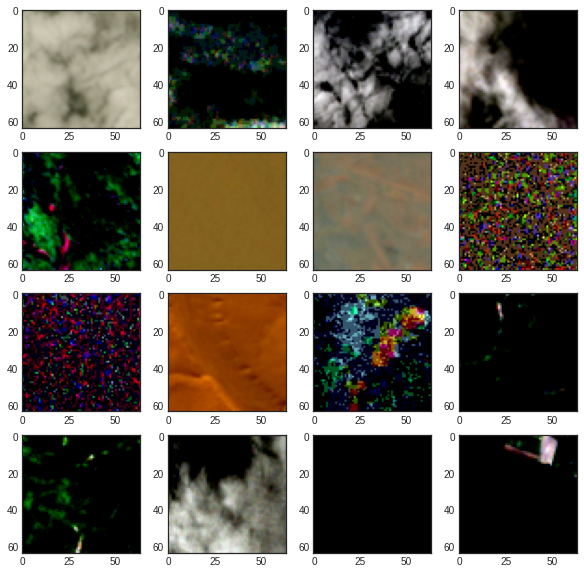

In [ ]:
plot_data_loader(train_loader, (4,4))

**Load VGG16 Model with Batch Normalization** 

In [ ]:
model = models.vgg16_bn()  # By default, no pre-trained weights are used.
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

**Change the number of outputs classes in the last layer of the model**

In [ ]:
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)  #num_classes = 4
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

**Set the hyperparameters**

In [ ]:
# define the loss function for multi-class classifictaion
criterion = nn.CrossEntropyLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001,  amsgrad=False)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)

# create and early stopping object which will be used during the training
early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

num_epochs = 2

**Train the Model with train_loader and perform validation with valid_loader**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion = criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    path_to_save_model=path_to_save_model,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/002 | Batch 0000/0106 | Loss: 1.3783
Epoch: 001/002 | Batch 0100/0106 | Loss: 1.1774
Epoch: 001/002 | Train ACC: 39.06% | Validation ACC: 54.00%| Train LOSS: 4.5414| Validation LOSS: 0.0409
Time elapsed: 19.27 min


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 002/002 | Batch 0000/0106 | Loss: 1.3460
Epoch: 002/002 | Batch 0100/0106 | Loss: 1.1899
Epoch: 002/002 | Train ACC: 39.06% | Validation ACC: 54.88%| Train LOSS: 1.1558| Validation LOSS: 0.0320
Time elapsed: 19.65 min
Total Training Time: 19.65 min
Saving FINAL model weights 


**Test Accuracy and test loss**

In [ ]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=device)
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

Test Accuracy 53.94%
Test Loss 0.0320


**Plot the Training Mini_Batch_loss**

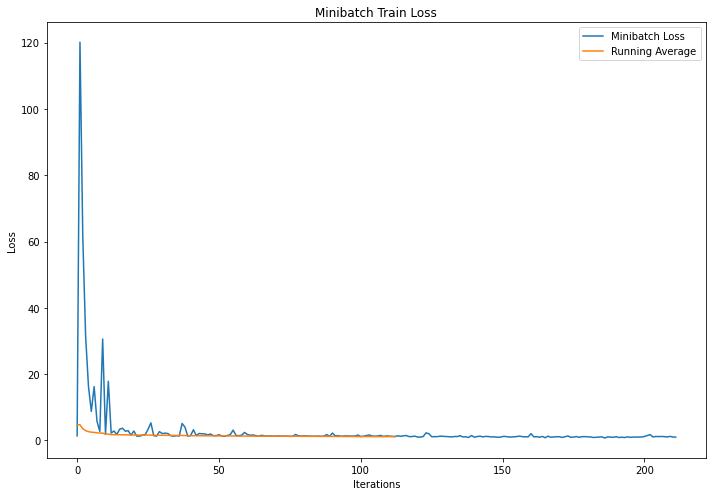

In [ ]:
plot_training_batch_loss(minibatch_loss_list, num_epochs, len(train_loader))
plt.show()

**Plot train vs Validation Accuracy**

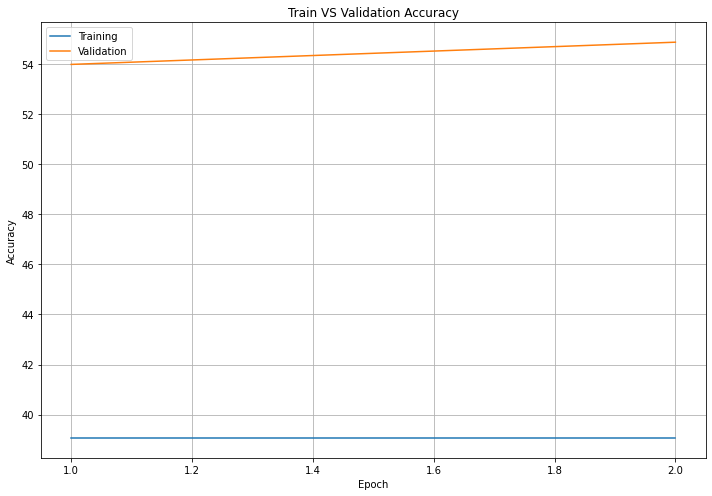

In [ ]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

**Plot train vs Validation Loss**

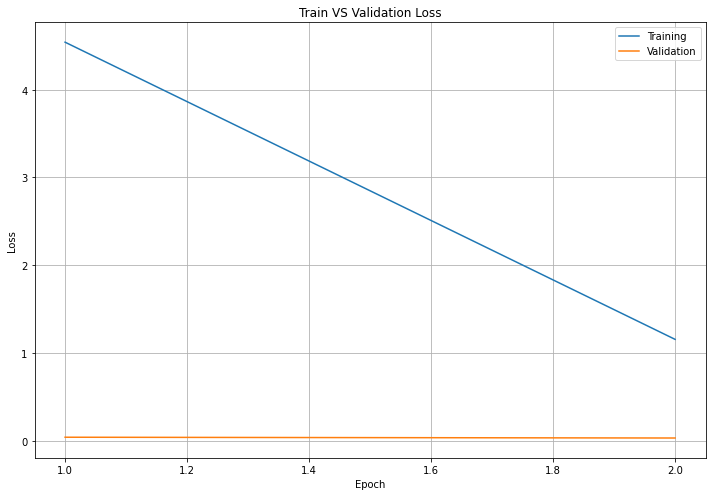

In [ ]:
plot_loss(train_loss_list, valid_loss_list)
plt.show()

**Confusion Matrix**

In [ ]:
label_encoding = data.class_to_idx  #{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
# label_encoding = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}  # needed while prediciting
class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

In [ ]:
label_encoding

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

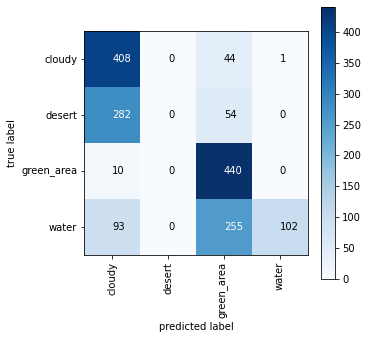

In [ ]:
confusion_matrix = compute_confusion_matrix(model = model, data_loader = test_loader, device=torch.device('cpu'))
plot_confusion_matrix(confusion_matrix, class_names = class_dict.values())
plt.show()

**F1 Score, Precision and Recall**

In [ ]:
print(compute_classification_report(test_loader, model))

              precision    recall  f1-score   support

           0       0.91      0.52      0.66       793
           1       0.00      0.00      0.00         0
           2       0.97      0.55      0.70       792
           3       0.23      1.00      0.38       104

    accuracy                           0.56      1689
   macro avg       0.53      0.52      0.43      1689
weighted avg       0.89      0.56      0.66      1689



**Predicted labels Visualization**

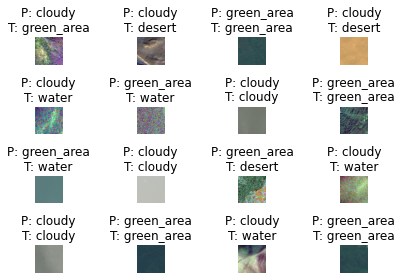

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

**Load the saved model to make predictions**

In [ ]:
model = models.vgg16_bn() # we do not specify pretrained=True, i.e. do not load default weights
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)  #num_classes = 4

model.load_state_dict(torch.load(path_to_save_model+'FINAL_MODEL_WEIGHTS.pt'))
model.eval()